### Checkout https://github.com/moshesipper/vae-torch-celeba/tree/main

In [1]:
import torch

In [2]:
SAVED_MODEL_PATH = '/projectnb/ds598/admin/xthomas/sp2024_notebooks/discussion/tmp/vae_model_20.pth'
# here: https://github.com/moshesipper/vae-torch-celeba/blob/main/vae_model_20.pth

In [3]:
import torch
from torch import nn
from torchvision import transforms

CELEB_PATH = '/projectnb/ds598/admin/xthomas/sp2024_notebooks/discussion/tmp/data/'
IMAGE_SIZE = 150
LATENT_DIM = 128
image_dim = 3 * IMAGE_SIZE * IMAGE_SIZE  # 67500
print('\nCELEB_PATH', CELEB_PATH, 
      'IMAGE_SIZE', IMAGE_SIZE, 
      'LATENT_DIM', LATENT_DIM, 
      'image_dim', image_dim)

celeb_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, antialias=True),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()])  # used when transforming image to tensor

celeb_transform1 = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, antialias=True),
    transforms.CenterCrop(IMAGE_SIZE)])  # used by decode method to transform final output


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        hidden_dims = [32, 64, 128, 256, 512]
        self.final_dim = hidden_dims[-1]
        in_channels = 3
        modules = []

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        out = self.encoder(torch.rand(1, 3, IMAGE_SIZE, IMAGE_SIZE))
        self.size = out.shape[2]
        self.fc_mu = nn.Linear(hidden_dims[-1] * self.size * self.size, LATENT_DIM)
        self.fc_var = nn.Linear(hidden_dims[-1] * self.size * self.size, LATENT_DIM)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(LATENT_DIM, hidden_dims[-1] * self.size * self.size)
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3,
                      kernel_size=3, padding=1),
            nn.Sigmoid())

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(-1, self.final_dim, self.size, self.size)
        result = self.decoder(result)
        result = self.final_layer(result)
        result = celeb_transform1(result)
        result = torch.flatten(result, start_dim=1)
        result = torch.nan_to_num(result)
        return result

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var


CELEB_PATH /projectnb/ds598/admin/xthomas/sp2024_notebooks/discussion/tmp/data/ IMAGE_SIZE 150 LATENT_DIM 128 image_dim 67500


Files already downloaded and verified


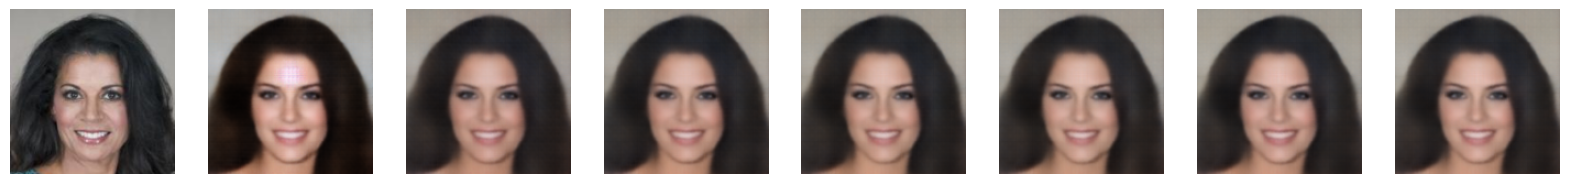

In [12]:
import torch
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
from torchvision.utils import save_image

from vae import VAE, CELEB_PATH, celeb_transform, IMAGE_SIZE, LATENT_DIM

# set torchvisions.datasets download path
import os
os.environ['TORCHVISION_DATASETS'] = '/projectnb/ds598/admin/xthomas/sp2024_notebooks/discussion/tmp/data/'
MODEL_FILE = SAVED_MODEL_PATH

dataset = CelebA(CELEB_PATH, transform=celeb_transform, download=True, split='valid')
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)
model = torch.load(MODEL_FILE, map_location='cpu')

for pic, _ in loader:  # batch size is 1, loader is shuffled, so this gets one random pic
    pics = pic.to('cpu')
    break
orig = torch.clone(pics)

for _ in range(7):
    recon, _, _ = model(pics)
    pic = recon[0].view(1, 3, IMAGE_SIZE, IMAGE_SIZE)
    pics = torch.cat((pics, pic), dim=0)

# plot the images
pics = pics.detach().numpy()
pics = pics.transpose(0, 2, 3, 1)
pics = pics.clip(0, 1)
fig, axs = plt.subplots(1, 8, figsize=(20, 10))
for i, ax in enumerate(axs):
    ax.imshow(pics[i])
    ax.axis('off')
plt.show()

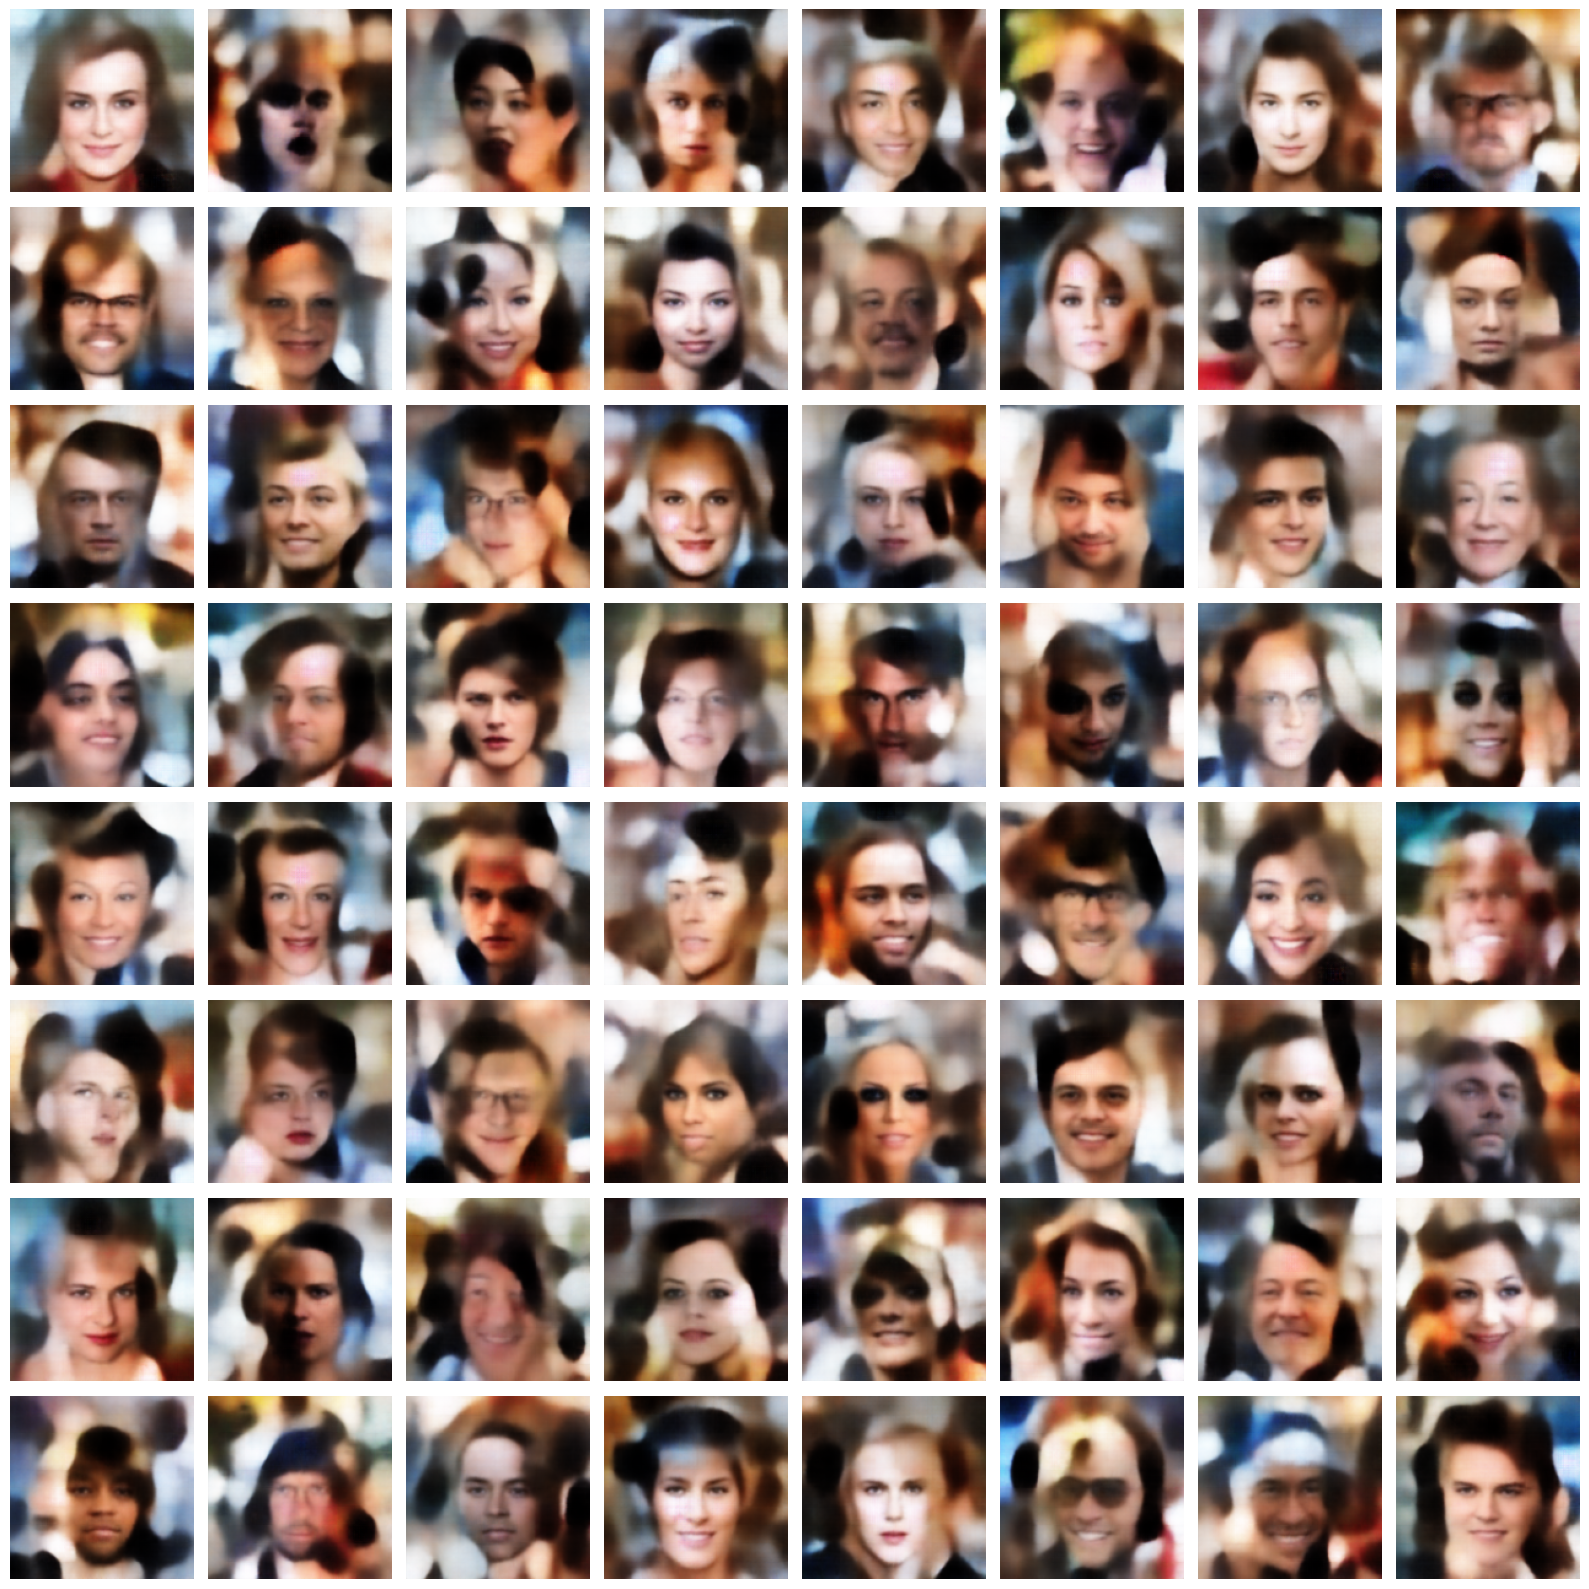

In [9]:
# Show 64 images in a 8x8 grid generated from random samples from the latent space

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(8, 8, figsize=(16, 16))
for i in range(8):
    for j in range(8):
        w = 1e-11
        z = torch.randn(1, LATENT_DIM)
        recon = model.decode(z)
        img = recon[0].view(3, IMAGE_SIZE, IMAGE_SIZE).detach().numpy()
        img = np.moveaxis(img, 0, -1)
        img = np.clip(img, 0, 1)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


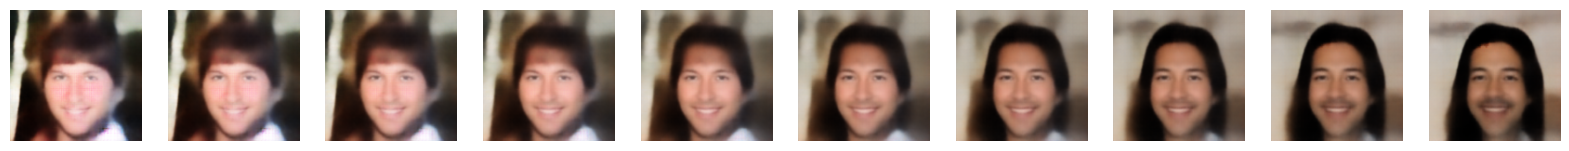

In [16]:
# Interpolating between two images
def interpolate(model, img1, img2, steps=10):
    z1, _ = model.encode(img1)
    z2, _ = model.encode(img2)
    zs = torch.cat([z1 + (z2 - z1) * t / steps for t in range(steps)])
    recons = model.decode(zs)
    recons = recons.view(steps, 3, IMAGE_SIZE, IMAGE_SIZE)
    recons = recons.detach().numpy()
    recons = np.moveaxis(recons, 1, -1)
    recons = np.clip(recons, 0, 1)
    return recons

img1 = next(iter(loader))[0]
img2 = next(iter(loader))[0]
interpolated = interpolate(model, img1, img2, steps=10)

fig, axs = plt.subplots(1, 10, figsize=(20, 10))
for i, ax in enumerate(axs):
    ax.imshow(interpolated[i])
    ax.axis('off')
plt.show()

In [19]:
import torch
import numpy as np
from PIL import Image
from IPython.display import Image as IPythonImage

def interpolate_gif(model, filename, img1, img2, steps=100):
    z1, _ = model.encode(img1.to('cpu'))
    z2, _ = model.encode(img2.to('cpu'))
    zs = torch.stack([z1 + (z2 - z1) * t for t in torch.linspace(0, 1, steps)])

    recons = model.decode(zs).view(steps, 3, IMAGE_SIZE, IMAGE_SIZE)
    recons = recons.detach().numpy().transpose(0, 2, 3, 1)  # reshape to (steps, IMAGE_SIZE, IMAGE_SIZE, 3)
    recons = np.clip(recons * 255, 0, 255).astype(np.uint8)

    images_list = [Image.fromarray(img) for img in recons]
    images_list = images_list + images_list[::-1]  # loop back to the beginning

    images_list[0].save(
        f'celeba.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=0,  # 0 for infinite loop
        duration=100  # frame duration in ms
    )
    
    return IPythonImage(filename=f'celeba.gif')

img1 = next(iter(loader))[0]
img2 = next(iter(loader))[0]

gif = interpolate_gif(model, 'celeba', img1, img2, steps=100)
gif

In [53]:
def add_features(model, img1, img2):
    """
    Adds the features of two images using a given model's latent space.

    :param model: The model with encode and decode methods (like a VAE).
    :param img1: The first image tensor.
    :param img2: The second image tensor.
    :return: The image resulting from adding the features of img1 and img2.
    """
    
    # Encode the images to get their latent representations
    z1, _ = model.encode(img1)
    z2, _ = model.encode(img2)
    
    # Combine the latent representations
    combined_z = (z1 + z2) / 2

    # Decode the combined representation to get the merged image
    merged_img = model.decode(combined_z)

    merged_img = merged_img.view(3, IMAGE_SIZE, IMAGE_SIZE)

    return merged_img

# Load two images
img1 = next(iter(loader))[0]
img2 = next(iter(loader))[0]

combined_img = add_features(model, img1, img2)

# Prepare the images for plotting
# Assuming the images are normalized in the range [0, 1]
img1_np = img1.squeeze().permute(1, 2, 0).numpy()  # Convert to [H, W, C] for plotting
img2_np = img2.squeeze().permute(1, 2, 0).numpy()
print(combined_img.shape)
combined_img_np = combined_img.squeeze().permute(1, 2, 0).detach().numpy()

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img1_np)
axs[0].set_title('Image 1')
axs[0].axis('off')

axs[1].imshow(img2_np)
axs[1].set_title('Image 2')
axs[1].axis('off')

axs[2].imshow(combined_img_np)
axs[2].set_title('Combined Image')
axs[2].axis('off')

plt.show()

torch.Size([3, 150, 150])
